In [3]:
!pip install wget
!pip install tables==3.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=47bf30db66f37938d37aa83fa6e1c072329a27325a7f6978c2770fde99ace284
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 56.6 MB/s eta 0:00:00
  Attempting uninstall: tables
    Found existing installation: tables 3.7.0
    Uninstalling tables-3.7.0:
      Successfully uninstalled tables-3.7.0


In [1]:
import os,sys

from google.colab import drive
drive.mount('/content/drive')
sys.path.append("/content/drive/My Drive/Collab/collab_v1")
%cd "/content/drive/My Drive/Collab/collab_v1"

Mounted at /content/drive
/content/drive/My Drive/Collab/collab_v1


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#some plotting routines
import plotting

# data processing
import data_higgs as dh

%tensorflow_version 2.x
#import the working methods
import tensorflow as tf
print("TensorFlow version ",tf.__version__)

from tensorflow import keras
print("TF Keras version ",tf.keras.__version__)


from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version  2.9.2
TF Keras version  2.9.0


In [5]:
#--------- globals

# Need to see a large portion of the data before we can build a layer, for
# example half of data n_batches_per_layer =  NBATCH_FRAC * NUM_EXAMPLES / BATCH_SIZE
BATCH_SIZE = 100

# Seed value
# Apparently you may use different seed values at each stage
SEED_VALUE= 10001
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED_VALUE)

In [6]:
#-------- routines

def split_xy(rawdata):
    #split features and labels from data 
    #prepare the data => normalizations !   

    # split 
    data_y=rawdata['hlabel'] # labels only: 0.=bkg, 1.=sig
    data_x=rawdata.drop(['hlabel'], axis=1) # features only
    
    #now prepare the data
    mu = data_x.mean()
    s = data_x.std()
    dmax = data_x.max()
    dmin = data_x.min()

    # normal/standard rescaling 
    #data_x = (data_x - mu)/s

    # scaling to [-1,1] range
    #data_x = -1. + 2.*(data_x - dmin)/(dmax-dmin)

    # scaling to [0,1] range
    data_x = (data_x - dmin)/(dmax-dmin)


    return data_x,data_y

In [7]:
def main(nepoch=10):
      # Training progress and eval results are shown as logging.INFO; so enables it.
 
    #needs to be done once if the h5 files need to be recreated...
    #dh.download_and_make_data()

    hdata=dh.load_data()
    data_fnames=hdata['feature_names'].to_numpy()[1:] #drop labels
    n_dims=data_fnames.shape[0]
    print ("Entries read {} with feature names {}".format(n_dims,data_fnames))

    x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
    x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
    x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample

    print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))

    #plot distributions
    plotting.plot_sig_bkg_from_np_arrays(x_train.to_numpy(),y_train.to_numpy(),data_fnames,logy=False)

    # ready the data for TF
    ds_train = tf.data.Dataset.from_tensor_slices((x_train.to_numpy(),y_train.to_numpy()))
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(BATCH_SIZE,drop_remainder=True)

    ds_test = tf.data.Dataset.from_tensor_slices((x_test.to_numpy(),y_test.to_numpy()))
    ds_test = ds_test.repeat()
    ds_test = ds_test.batch(BATCH_SIZE,drop_remainder=True)

    train_steps=int(x_train.shape[0]/BATCH_SIZE)
    test_steps=int(x_test.shape[0]/BATCH_SIZE)
    print("Steps train:{} and test:{}".format(train_steps,test_steps))
    
    # build a model - a DNN in TF 2.0 
    dnn = Sequential()
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    plot_model(dnn, to_file='dnn_model.png', show_shapes=True)

    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy', 'AUC', 'binary_crossentropy'])

    dnn.summary()

    #optional early stopping
    eval_metric = 'AUC'
    earlystop_callback = EarlyStopping(
            mode='max',
            monitor='val_' + eval_metric,
            patience=5,
            min_delta=0.00001,
            verbose=1
        )
    
    #run the training
    dnn_model_history = dnn.fit(ds_train,
            epochs=nepoch,
            steps_per_epoch=train_steps,
            #callbacks=[earlystop_callback],
            validation_data=ds_test,
            validation_steps=test_steps
        )

    #plot training history
    print("history values",dnn_model_history.history.keys())
    plotting.plot_history([('DNN model', dnn_model_history),],key='binary_crossentropy')
    plotting.plot_history([('DNN model', dnn_model_history),],key='auc')
    plotting.plot_history([('DNN model', dnn_model_history),],key='accuracy')

    #plot & print results like ROC and score distribution etc...
    y_score=dnn.predict(x_val.to_numpy())[:,0]
    plotting.plot_roc(y_val,y_score)
    plotting.plot_score(y_val,y_score)
    print()
    auc=roc_auc_score(y_val,y_score)
    print("AUC score: {}".format(auc))


Loading /content/drive/MyDrive/Collab/collab_v1/data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)


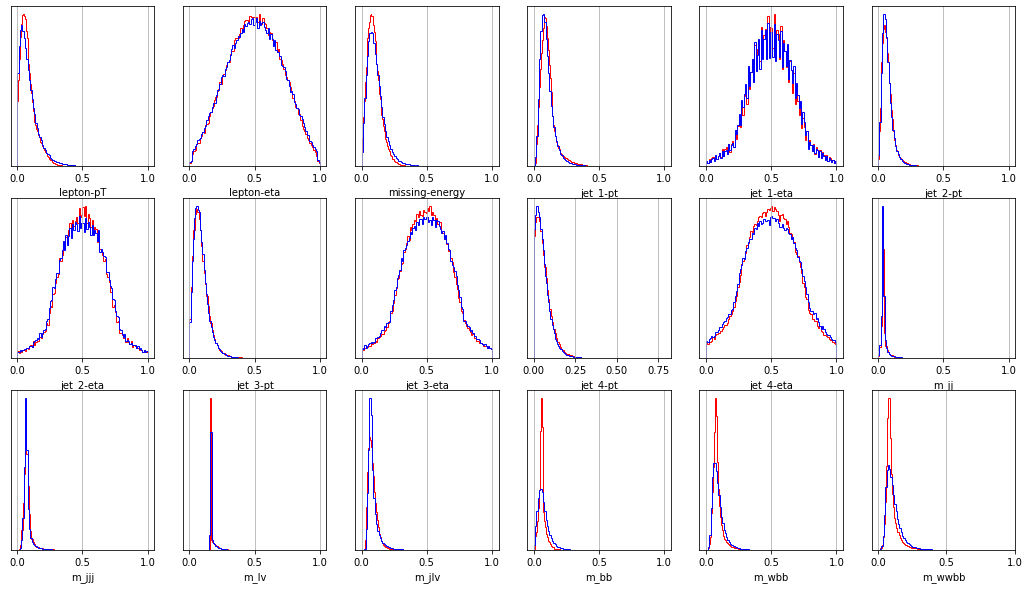

Steps train:3600 and test:400
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                950       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,551
Trainable params: 3,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
3600/3600 [==============================] - 18s 4ms/step - loss: 0.6362 - accuracy: 0.6309 - auc: 0.6830 - binary_crossentropy: 0.6362 - val_loss: 0.6143 - val_accuracy: 0.6582 - val_auc: 0.7239 - val_binary_crossentropy: 0.6143
Epoch 2/4
3600/3600 [===========================

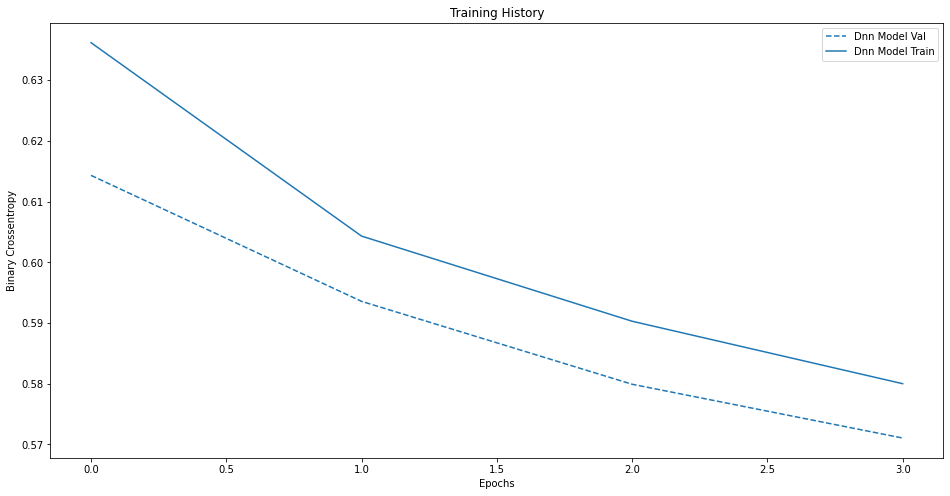

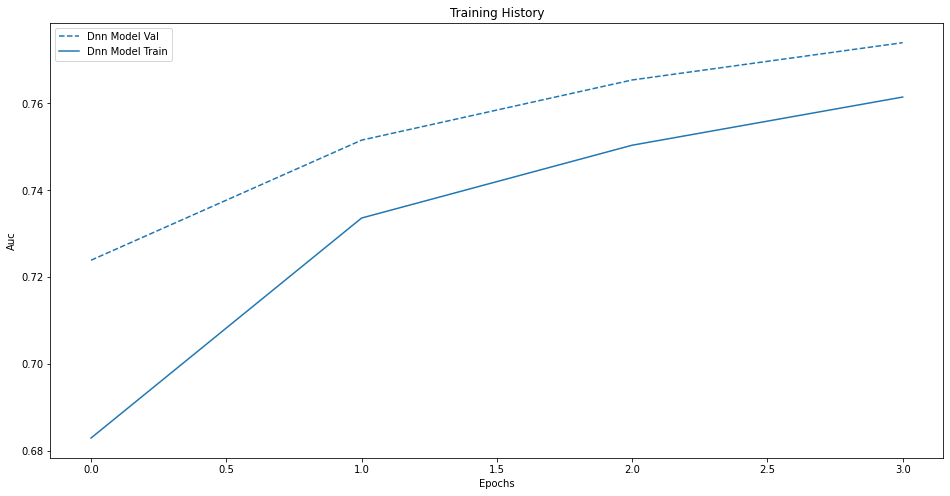

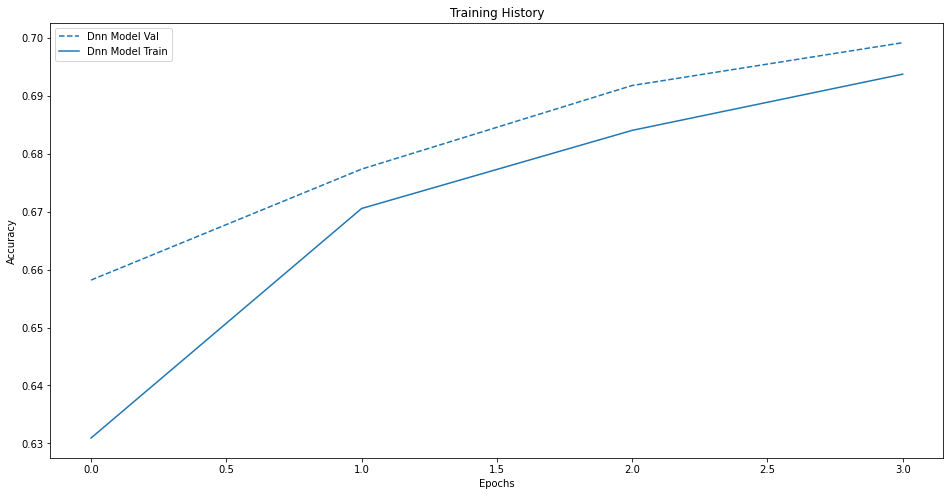

3125/3125 [==============================] - 5s 2ms/step


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))



AUC score: 0.7489578628366714


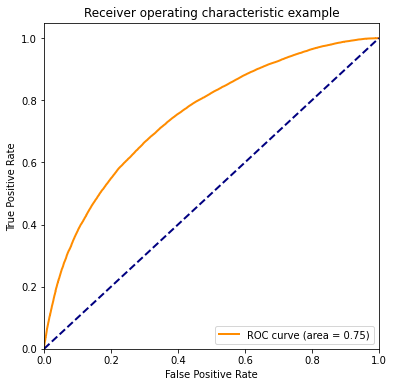

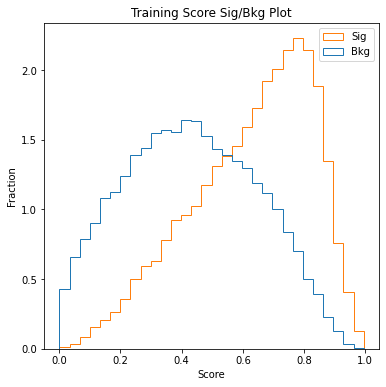

In [8]:
main(4)